### Step 1. Setup and initial data inspection

In [1]:
import pandas as pd
import numpy as np
import catboost
import math
import matplotlib.pyplot as plt
from catboost import cv
from catboost import *
from catboost import datasets
from sklearn.model_selection import train_test_split
import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [2]:
def features_creating(df):
    df['bmi'] = df['weight']/((df['height']/100)**2) #creating feature with body mass index
    df['pp'] = df['ap_hi'] - df['ap_lo'] #creating feature with pulse pressure

In [3]:
df_train = pd.read_csv('train.csv',index_col='id')
df_test = pd.read_csv('test.csv',index_col='id')

display(df_train)
display(df_test)

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,17474,1,156,56.0,100,60,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
99993,19240,2,168,76.0,120,80,1,1,1,0,1,0
99995,22601,1,158,126.0,140,90,2,2,0,0,1,1
99996,19066,2,183,105.0,180,90,3,1,0,1,0,1


,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active
id,,,,,,,,,,,
5,18888,1,154,85.0,130,80,1,1,0,0,1
6,19042,2,170,69.0,130,90,1,1,0,0,1
7,20432,1,160,70.0,120,75,1,1,0,0,0
10,18133,2,185,94.0,130,90,1,1,0,0,1
11,16093,2,170,76.0,120,80,1,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
99984,21722,2,170,103.0,150,90,1,1,0,1,0
99987,18309,1,172,78.0,110,70,1,1,0,0,1
99989,21247,2,169,61.0,120,80,1,1,0,0,0


In [4]:
display(df_train.describe())
df_train.info()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,19468.865814,1.349571,164.359229,74.205690,128.817286,96.630414,1.366871,1.226457,0.088129,0.053771,0.803729,0.499700
std,2467.251667,0.476838,8.210126,14.395757,154.011419,188.472530,0.680250,0.572270,0.283484,0.225568,0.397179,0.500003
min,10798.000000,1.000000,55.000000,10.000000,-150.000000,-70.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,17664.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,19703.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,21327.000000,2.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,23713.000000,2.000000,250.000000,200.000000,16020.000000,11000.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000


<class 'pandas.core.frame.DataFrame'>
Int64Index: 70000 entries, 0 to 99999
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          70000 non-null  int64  
 1   gender       70000 non-null  int64  
 2   height       70000 non-null  int64  
 3   weight       70000 non-null  float64
 4   ap_hi        70000 non-null  int64  
 5   ap_lo        70000 non-null  int64  
 6   cholesterol  70000 non-null  int64  
 7   gluc         70000 non-null  int64  
 8   smoke        70000 non-null  int64  
 9   alco         70000 non-null  int64  
 10  active       70000 non-null  int64  
 11  cardio       70000 non-null  int64  
dtypes: float64(1), int64(11)
memory usage: 6.9 MB


Based on the description of the data, we can see abnormally large values in the columns `height`,`weight`,`ap_hi` and `ap_lo`

### Step 2. Preprocessing and exploratory data analysis

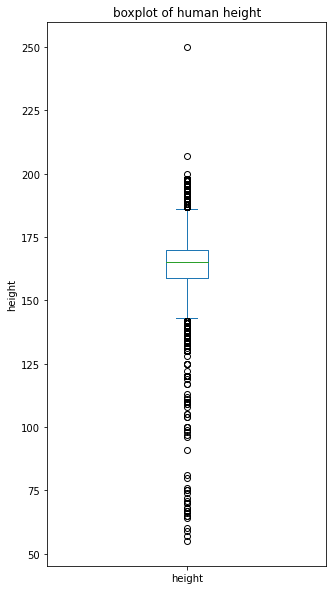

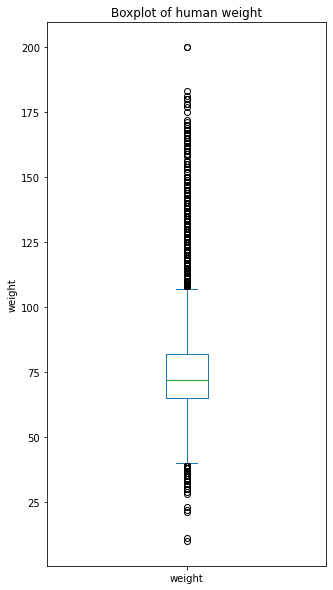

In [5]:
plt.figure(figsize=(5,10))
plt.title('boxplot of human height')
plt.ylabel("height")
df_train['height'].plot(kind='box')

plt.figure(figsize=(5,10))
plt.title('Boxplot of human weight')
plt.ylabel("weight")
df_train['weight'].plot(kind='box');

Based on the graph, we can see that there are abnormally low and high values, especially the height of 250 cm stands out from the overall picture

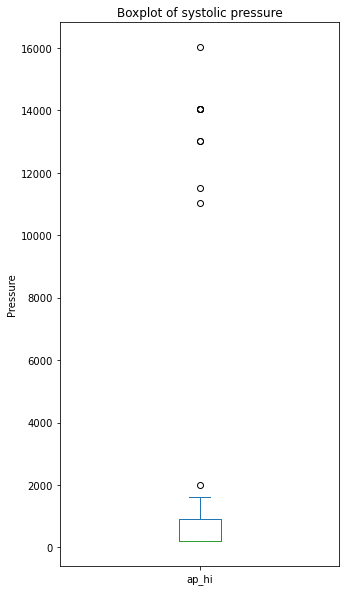

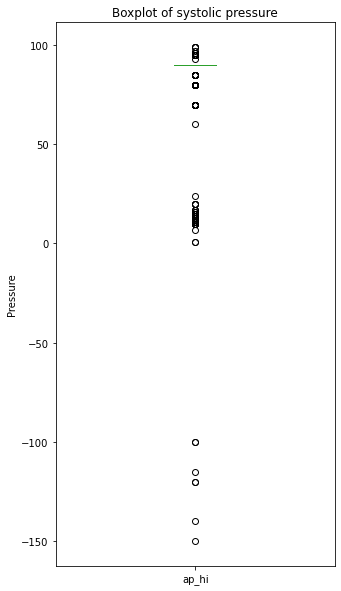

In [6]:
plt.figure(figsize=(5,10))
plt.title('Boxplot of systolic pressure')
plt.ylabel("Pressure")
df_train.query('ap_hi>200')['ap_hi'].plot(kind='box')

plt.figure(figsize=(5,10))
plt.title('Boxplot of systolic pressure')
plt.ylabel("Pressure")
df_train.query('ap_hi<100')['ap_hi'].plot(kind='box');

Systolic pressure less than 50 and more than 200 can be considered anomalies

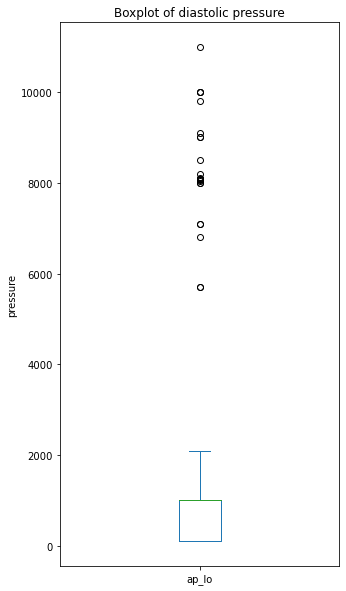

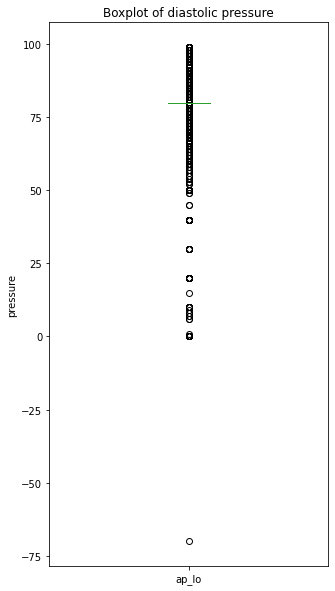

In [7]:
plt.figure(figsize=(5,10))
plt.title('Boxplot of diastolic pressure')
plt.ylabel("pressure")
df_train.query('ap_lo>100')['ap_lo'].plot(kind='box')

plt.figure(figsize=(5,10))
plt.title('Boxplot of diastolic pressure')
plt.ylabel("pressure")
df_train.query('ap_lo<100')['ap_lo'].plot(kind='box');

Diastolic pressure below 40 and above 4000 can be considered anomalies

In [8]:
df_dropped = df_train.query('height<200 and height>80 and weight<125 and weight>45 and ap_hi>50 and ap_hi<200 and ap_lo>40 and ap_lo<4000')

In [9]:
abs((df_dropped['age'].count()-df_train['age'].count())/df_train['age'].count()*100)

1.8614285714285714

After the anomaly removal procedure, we lost less than 2% of the data

### Step 3. Creating new features

In [10]:
features_creating(df_dropped)
features_creating(df_test)

In [11]:
df_dropped

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,bmi,pp
id,,,,,,,,,,,,,,
0,18393,2,168,62.0,110,80,1,1,0,0,1,0,21.967120,30
1,20228,1,156,85.0,140,90,3,1,0,0,1,1,34.927679,50
2,18857,1,165,64.0,130,70,3,1,0,0,0,1,23.507805,60
3,17623,2,169,82.0,150,100,1,1,0,0,1,1,28.710479,50
4,17474,1,156,56.0,100,60,1,1,0,0,0,0,23.011177,40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99992,21074,1,165,80.0,150,80,1,1,0,0,1,1,29.384757,70
99993,19240,2,168,76.0,120,80,1,1,1,0,1,0,26.927438,40
99996,19066,2,183,105.0,180,90,3,1,0,1,0,1,31.353579,90


### Step 4. CatBoost model training and obtaining probability predictions

In [12]:
df_dropped['cardio'].value_counts()

0    34424
1    34273
Name: cardio, dtype: int64

The imbalance of targets is small, no corrections are required.

In [13]:
features = df_dropped.drop(['cardio'],axis=1)
features_test = df_test

target=df_dropped['cardio']

In [14]:
features, features_valid, target, target_valid = train_test_split(  #Dividing the sample
features, target,test_size=0.25,random_state=5678)


In [15]:
cats = [1,8,9,10] #selection of categorical features

In [16]:
model = CatBoostClassifier(
    loss_function = 'Logloss',
    iterations = 20000,
    custom_loss = 'AUC',
    random_seed = 12345,
    learning_rate = 0.02,
    l2_leaf_reg = 3,
    bagging_temperature = 1,
    random_strength = 1,
    one_hot_max_size = 2,
    leaf_estimation_method = 'Newton',
    early_stopping_rounds = 150
)
model.fit(
    features, target,
    cat_features=cats,
    eval_set=(features_valid, target_valid),
    verbose=False,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [17]:
predictions = model.predict_proba(features_test)[:,1]